In [3]:
# Copyright 2018 Anar Amirli
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

### Scaling and role assignment visualisation
In this notebook, we visualize player avrg position (before and after scaling states) by drawing their average position using matplotlip. And also show example of role assignment. 

__How we assign role to each player?__
* Define which player's in the game.
* Generate players' average positions based on their position in the timeline of previous 15 minutes.
* Each minute update their average position.
* Scale average positions to the range of *(105+std)(68-std)* meters based on their standard deviation of averge position data.
* Seperate pitch into different role-based segments
* Find on wich segment its average position is located.
* Assign role to it based on this sector.

In [26]:
role_dict = {
    0: 'LeftBack',
    1: 'CenterBack',
    2: 'RightBack',
    3: 'LeftWinger',
    4: 'CenterMiddle',
    5: 'RightWinger',
    6: 'CenterForward'
}

In [27]:
role_segment_coord = [[0, 40, 0, 19],    # Left Back 
                      [0, 35, 19, 49],   # Center Back
                      [0, 40, 49, 68],   # Right Back
                      [40, 105, 0, 19],  # Left Winger
                      [35, 75, 19, 49],  # Center Midfielder
                      [40, 105, 49, 68], # Right Winger
                      [75, 105, 19, 49]] # Center Forward/Attacking Middle

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from IPython import display
import matplotlib.lines as mlines

pd.options.display.max_columns = None

pd.set_option('compute.use_bottleneck', True)
pd.set_option('compute.use_numexpr', True)

**Scaling down positions to the range of min and max based on their standard deviations**

$$p=\{ p_{1}, p_{2}..., p_{n}\}$$<br>
$$p_{scale_{i}}=\frac{d_{high}-((d_{high}-STD_{p})-(d_{low}+STD_{p}))(p_{max}-p_{i}) }{p_{max}-p_{min}}$$

In [2]:
def scale_linear_data(rawpoints, high, low, std):
    '''
    Function for sclaing player avrg position to the to the range of (105+std)(68-std)
    
    Parameters
    ----------
    rawpoints: player average pos data
    
    high: furthest point of scaling range
    
    low: lowest point of scaling range
    
    std: standard deviation of player positions 
    
    '''
    mins = np.min(rawpoints, axis=0)
    maxs = np.max(rawpoints, axis=0)
    rng = maxs - mins
    high = high - std
    low = low + std
    return high - (((high - low) * (maxs - rawpoints)) / rng)

**Role defining**

In [1]:
def define_role(x, y, pitch_value, gk_state):
    '''
    Function to define players role in the game
    
    Parameters
    ----------
    x, y: coordinates
    
    pitch_value: pitch segment value
    
    Returns
    -------
    1-6: players rolse assigment indexes
      7: goalkeeper
     -1: player is not in game
    
    '''
    # gk_state==1 := golakeeper
    if gk_state==1:
        return 7
    else:
        for pitch_i in range(0,7):
            if x>=pitch_value[pitch_i][0] and x<pitch_value[pitch_i][1] and y>=pitch_value[pitch_i][2] and y<pitch_value[pitch_i][3]:
                return pitch_i
    return -1

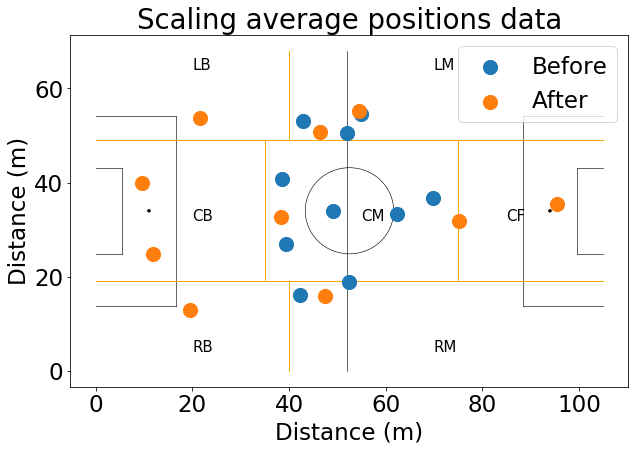

Players' role assignation

[ 11.85219552  24.88572765] -> CenterBack
[  9.61546172  39.9642036 ] -> CenterBack
[ 54.51582183  55.16383605] -> RightWinger
[ 47.52948043  15.90913312] -> LeftWinger
[ 46.42492053  50.6810459 ] -> RightWinger
[ 38.36163322  32.65075726] -> CenterMiddle
[ 95.38453828  35.51445613] -> CenterForward
[ 21.57232268  53.67691548] -> RightBack
[ 19.52888686  12.83616395] -> LeftBack
[ 75.17109204  31.82469028] -> CenterForward


In [31]:
match_id = 60656

try:
    avrg_pos = np.load('../data/match_{}/averga_pose_smp.npy'.format(match_id))
except FileNotFoundError:
    avrg_pos = None

font = {'size'   : 23}

matplotlib.rc('font', **font)

width, height = 105, 68
plt.figure(figsize=(10, 10*height/width))

plt.xlabel('Distance (m)')
plt.ylabel('Distance (m)')

size = 200
ax = plt.gca()
mid_circ = plt.Circle((52.5, 34), 9.15, color='black', fill=False, linewidth=0.6, zorder=1)
left_pen_circ = plt.Circle((11, 34), 0.3, color='black', fill=True, linewidth=0.6, zorder=1)
right_pen_circ = plt.Circle((94, 34), 0.3, color='black', fill=True, linewidth=0.6, zorder=1)
# middle line
ax.add_line(mlines.Line2D((52, 52), (0, 68), color='black', linewidth=0.6, zorder=1))

# circles
ax.add_artist(mid_circ)
ax.add_artist(left_pen_circ)
ax.add_artist(right_pen_circ)

# left part
ax.add_line(mlines.Line2D((0, 16.5), (13.84, 13.84), color='black', linewidth=0.6, zorder=1))
ax.add_line(mlines.Line2D((0, 16.5), (54.16, 54.16), color='black', linewidth=0.6, zorder=1))
ax.add_line(mlines.Line2D((16.5, 16.5), (13.84, 54.16), color='black', linewidth=0.6, zorder=1))

ax.add_line(mlines.Line2D((0, 5.5), (24.84, 24.84), color='black', linewidth=0.6, zorder=1))
ax.add_line(mlines.Line2D((0, 5.5), (43.16, 43.16), color='black', linewidth=0.6, zorder=1))
ax.add_line(mlines.Line2D((5.5, 5.5), (24.84, 43.16), color='black', linewidth=0.6, zorder=1))

# right part
ax.add_line(mlines.Line2D((88.5, 105), (13.84, 13.84), color='black', linewidth=0.6, zorder=1))
ax.add_line(mlines.Line2D((88.5, 105), (54.16, 54.16), color='black', linewidth=0.6, zorder=1))
ax.add_line(mlines.Line2D((88.5, 88.5), (13.84, 54.16), color='black', linewidth=0.6, zorder=1))

ax.add_line(mlines.Line2D((99.5, 105), (24.84, 24.84), color='black', linewidth=0.6, zorder=1))
ax.add_line(mlines.Line2D((99.5, 105), (43.16, 43.16), color='black', linewidth=0.6, zorder=1))
ax.add_line(mlines.Line2D((99.5, 99.5), (24.84, 43.16), color='black', linewidth=0.6, zorder=1))

# role division
ax.add_line(mlines.Line2D((35, 35), (19, 49), color='orange', linewidth=1, zorder=1))
ax.add_line(mlines.Line2D((40, 40), (0, 19), color='orange', linewidth=1, zorder=1))
ax.add_line(mlines.Line2D((40, 40), (49, 68), color='orange', linewidth=1, zorder=1))
ax.add_line(mlines.Line2D((75, 75), (19, 49), color='orange', linewidth=1, zorder=1))
ax.add_line(mlines.Line2D((0, 105), (19, 19), color='orange', linewidth=1, zorder=1))
ax.add_line(mlines.Line2D((0, 105), (49, 49), color='orange', linewidth=1, zorder=1))

ax.text(20, 64, 'LB', fontsize=15)
ax.text(20, 32, 'CB', fontsize=15)
ax.text(20, 4,  'RB', fontsize=15)
ax.text(70, 64, 'LM', fontsize=15)
ax.text(55, 32, 'CM', fontsize=15)
ax.text(70, 4,  'RM', fontsize=15)
ax.text(85, 32, 'CF', fontsize=15)

plt.title('Scaling average positions data')
plt.scatter(avrg_pos[:,0],avrg_pos[:,1], label='Before', s=size, zorder=2)

# find standard deviation of avrg pos data 
stdX = np.std(avrg_pos[:,0])
stdY = np.std(avrg_pos[:,1])

# sclaing 
avrg_pos[:,0] = scale_linear_data(avrg_pos[:,0], 105, 0, stdX)
avrg_pos[:,1] = scale_linear_data(avrg_pos[:,1], 68, 0, stdY)


plt.scatter(avrg_pos[:,0],avrg_pos[:,1], label='After', s=size, zorder=2)
plt.legend(loc=1)
plt.show()


print("Players' role assignation\n")
for player in avrg_pos:
    role = define_role(player[0],player[1], role_segment_coord, 0)
    print(str(player) + " -> " + role_dict[role]) 